# Extract SWE data from SnowModel output and export to NetCDF
3/18-16/2020. Emilio

## From Nina

Possible tracking parameters:

1. Total daily water volume by watershed
    - could be aggregated to monthly resolution for GRACE 
2. Total daily change in water volume by watershed classified by:
    - Elevation 
    - Aspect 
    - Slope 
    - Landcover 
3. PDFs and CDFs of SWE change by watershed
4. Watershed hypsometry 
5. Watershed SWE hypsometry 
6. Percent snow covered area by watershed 
    - Could compare to MODIS-derived daily snow covered area
7. Considering there may not be a ‘best’ calibration/assimilation run, with different parameters performing better at certain SNOTEL stations, we could select the top 3-5 combinations of parameters to create a SWE ensemble. Visual would be a time series of the uncertainty in daily SWE based off an ensemble of parameters or assimilation combinations

## MinIO
- https://docs.min.io/docs/minio-quickstart-guide.html
- https://docs.min.io/docs/minio-docker-quickstart-guide
- https://blog.alexellis.io/meet-minio/
- See the other links I entered into RedNotebook, 3/10/2020 

### References for NetCDF CF/ACDD conventions
- https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/
- https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/grid.cdl

### Strategies, TO-DOs
- Plan to create a set of netcdf files segmented by time, say, one per year, with the file name encoding the time slice. eg, `swed_gdat_2014.nc`. 
- That series files can then be opened with `xarray.open_mfdataset`, which uses lazy loading (!).
- Alternatively, later, it may be more practical to read the binary data in the same time segments, and write to zarr instead if such writing allows for concatenation along the time dimension
- DONE. Add dimension variables (time, x, y), with corresponding attributes.
- Add more global attributes, including ones matching with CF conventions.
- Add more variable attributes, including CF standard name

In [1]:
import os
from collections import OrderedDict

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters defining the XYT dimensions, file name, etc

In [2]:
##USER INPUTS## - most of this can be read directly from the .ctl file or the .par file 
#-> need to read in text file

# model filename
inFile = 'swed.gdat'

# start date
st = "2014-10-01"
# end date
ed = "2019-09-29"
# number of timesteps in model run 
num_mod_timesteps = 365 * 5

# from .ctl file
nx = 1382 # number of cells in the x dimension?
ny = 2476 # number of cells in the y dimension?
xll = 487200
yll = 4690100
clsz = 100 # cellsize?

In [3]:
#Build lat/lon array 
lon = np.arange(xll, xll+nx*clsz, clsz)
lat = np.arange(yll, yll+ny*clsz, clsz)

In [4]:
len(lon), len(lat), len(lon)*len(lat)

(1382, 2476, 3421832)

## Check file size vs dimensions

In [5]:
filesize_bytes = os.path.getsize(inFile)

In [6]:
# file size in bytes and GB's (using bit shift)
filesize_bytes, filesize_bytes >> 30

(24979373600, 23)

In [7]:
# confirm that dimensions match file size
# 32 bit (4 byte) floating point data
4 * num_mod_timesteps * (len(lon)*len(lat)) == filesize_bytes

True

## Read only a small portion of the file, for testing
I can't read it all at once b/c it's larger than my available laptop memory (23 GB vs 15.4 GB)

**Notes about `np.fromfile`:**

- Do not rely on the combination of `tofile` and `fromfile` for data storage, as the binary files generated are not platform independent.  In particular, no byte-order or data-type information is saved.  Data can be stored in the platform independent ``.npy`` format using `save` and `load` instead.
- `count : int.` Number of items to read. ``-1`` means all items (i.e., the complete file).

In [8]:
nxy = len(lon)*len(lat)
nts = 65 # number of time steps to read

In [9]:
# open grads model output file into a numpy array 
# using buffering=0 didn't make any apparent difference
with open(inFile, 'rb') as gradsfile:
    # other dtype options: 'float32', <f'
    numpy_data = np.fromfile(gradsfile, dtype=np.float32, count=nts*nxy)
    numpy_data = numpy_data.reshape((nts, ny, nx))

numpy_data.shape

(65, 2476, 1382)

NOTE: "lat" and "lon" actually look like Northing and Easting. Per Nina's notebook:
```python
mod_proj = 'epsg:32612' # UTM zone 12N
```

In [10]:
# Test byte swapping (changing endian order)
# numpy_data = numpy_data.byteswap(False)
# NOPE, didn't make things better

## Create xarray DataArray, including some variable attributes

In [11]:
time = pd.date_range(st, periods=nts) # periods=num_mod_timesteps

In [12]:
time

DatetimeIndex(['2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04',
               '2014-10-05', '2014-10-06', '2014-10-07', '2014-10-08',
               '2014-10-09', '2014-10-10', '2014-10-11', '2014-10-12',
               '2014-10-13', '2014-10-14', '2014-10-15', '2014-10-16',
               '2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20',
               '2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-25', '2014-10-26', '2014-10-27', '2014-10-28',
               '2014-10-29', '2014-10-30', '2014-10-31', '2014-11-01',
               '2014-11-02', '2014-11-03', '2014-11-04', '2014-11-05',
               '2014-11-06', '2014-11-07', '2014-11-08', '2014-11-09',
               '2014-11-10', '2014-11-11', '2014-11-12', '2014-11-13',
               '2014-11-14', '2014-11-15', '2014-11-16', '2014-11-17',
               '2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
      

In [13]:
# convert to xarray DataArray
swe = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': lat, 'x': lon}
)

DataArray at this point has no attributes at all. Add attributes like name, units, etc.

In [14]:
swe.attrs['long_name'] = 'Snow Water Equivalent'
swe.attrs['standard_name'] = 'lwe_thickness_of_surface_snow_amount'
swe.attrs['units'] = 'meters'

In [15]:
# for i in range(len(time)):
#     print(f"{i}: {float(swe[i,:,:].min())}, {float(swe[i,:,:].max())}, {float(swe[i,:,:].mean())}")

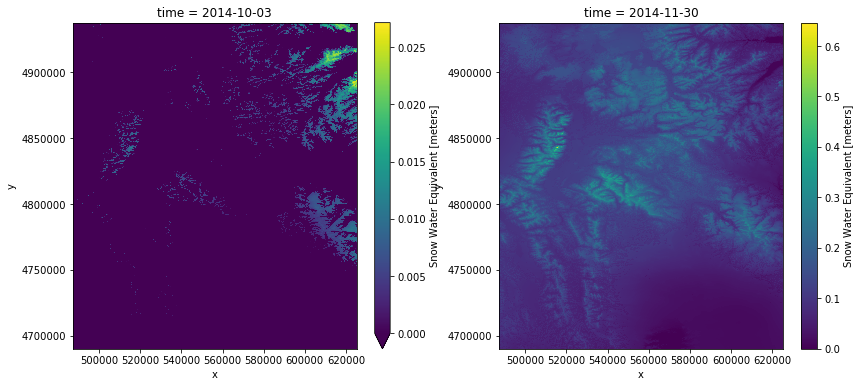

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
swe[2,:,:].plot(ax=ax[0], vmin=0)
swe[60,:,:].plot(ax=ax[1], vmin=0);

## Create xarray Dataset

In [17]:
d = OrderedDict()
d['time'] = ('time', time)
d['x'] = ('x', lon)
d['y'] = ('y', lat)
d['swe'] = swe

ds = xr.Dataset(d)

Add global and variable attributes

In [18]:
# Switch to using a dictionary (OrderdDict) to populate attributes

ds.attrs['description'] = "SnowModel model run, SWE variable only"
ds.attrs['CRS'] = "UTM Zone 12N, EPSG:32612"

ds.time.attrs['standard_name'] = "time"
ds.time.attrs['axis'] = "T"

ds.x.attrs['long_name'] = "Easting"
ds.x.attrs['units'] = "meters"
ds.x.attrs['axis'] = "X"

ds.y.attrs['long_name'] = "Northing"
ds.y.attrs['units'] = "meters"
ds.y.attrs['axis'] = "Y"

In [19]:
ds

<xarray.Dataset>
Dimensions:  (time: 65, x: 1382, y: 2476)
Coordinates:
  * time     (time) datetime64[ns] 2014-10-01 2014-10-02 ... 2014-12-04
  * x        (x) int64 487200 487300 487400 487500 ... 625100 625200 625300
  * y        (y) int64 4690100 4690200 4690300 ... 4937400 4937500 4937600
Data variables:
    swe      (time, y, x) float32 0.0 0.0 0.0 ... 0.040056106 0.058058538
Attributes:
    description:  SnowModel model run, SWE variable only
    CRS:          UTM Zone 12N, EPSG:32612

In [20]:
ds.swe.dims

('time', 'y', 'x')

In [21]:
ds.swe.attrs

{'long_name': 'Snow Water Equivalent',
 'standard_name': 'lwe_thickness_of_surface_snow_amount',
 'units': 'meters'}

### Export to netcdf

In [22]:
ds.to_netcdf('swed_gdat.nc', format='NETCDF4', engine='netcdf4')

Verify that the netcdf file looks ok

In [23]:
ds_read = xr.open_dataset('swed_gdat.nc')
ds_read

<xarray.Dataset>
Dimensions:  (time: 65, x: 1382, y: 2476)
Coordinates:
  * time     (time) datetime64[ns] 2014-10-01 2014-10-02 ... 2014-12-04
  * x        (x) int64 487200 487300 487400 487500 ... 625100 625200 625300
  * y        (y) int64 4690100 4690200 4690300 ... 4937400 4937500 4937600
Data variables:
    swe      (time, y, x) float32 ...
Attributes:
    description:  SnowModel model run, SWE variable only
    CRS:          UTM Zone 12N, EPSG:32612

In [24]:
!ncdump -h 'swed_gdat.nc'

netcdf swed_gdat {
dimensions:
	time = 65 ;
	x = 1382 ;
	y = 2476 ;
variables:
	int64 time(time) ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:units = "days since 2014-10-01 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
	int64 x(x) ;
		x:long_name = "Easting" ;
		x:units = "meters" ;
		x:axis = "X" ;
	int64 y(y) ;
		y:long_name = "Northing" ;
		y:units = "meters" ;
		y:axis = "Y" ;
	float swe(time, y, x) ;
		swe:_FillValue = NaNf ;
		swe:long_name = "Snow Water Equivalent" ;
		swe:standard_name = "lwe_thickness_of_surface_snow_amount" ;
		swe:units = "meters" ;

// global attributes:
		:description = "SnowModel model run, SWE variable only" ;
		:CRS = "UTM Zone 12N, EPSG:32612" ;
}
